In [ ]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [ ]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

def generate_points_distribution(data_num=2000, dist_type="circle"):
    if dist_type == 'spiral':
        theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
        radius = np.linspace(0, 0.3, data_num)  # 반지름 범위를 정의합니다.
        xx = 0.5 + radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = 0.5 + radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'box':
        xx = np.random.uniform(0.4, 0.8, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = np.random.uniform(0.2, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'curve':
        xx = np.linspace(0.15, 0.85, data_num) + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = 3.8 * xx*xx - 3.8 * xx + 1.2 + 0.03 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'circle':
        radius = 0.20
        theta = np.linspace(0, 2 * np.pi, data_num)  # 각도 범위를 정의합니다.
        xx = radius * np.cos(theta) + 0.5 + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = radius * np.sin(theta) + 0.55 + 0.02 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'lemniscate':
        xx = []
        yy = []
        while len(xx) < data_num:
            x = np.random.uniform(0, 0.5)
            y = np.random.uniform(0, 0.5)
            
            r = (x**2 + y**2)**0.5
            theta = np.arctan2(y, x)
            if r**2 <= 2 * 0.25**2 * np.cos(2 * theta):
                x = x if np.random.uniform(0, 1) < 0.5 else -x
                y = y if np.random.uniform(0, 1) < 0.5 else -y
                xx.append(x+0.5)
                yy.append(y+0.5)

    data = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
    np.random.shuffle(data)
    
    return data

In [ ]:
x = generate_points_distribution(2000, 'spiral')
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [ ]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
noise_qubits = 4
code_qubits = 2
n_qubits = noise_qubits + code_qubits
output_qubits = 2
assert(output_qubits <= noise_qubits) # 출력 큐빗은 noise qubit이하여야 한다.

n_layers = 20
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

In [ ]:
coeff = 0.2

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        #qml.RX(params[i][0], wires=i)
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])
        #qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[::2] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    generator_output = 2 * (2 / np.pi * torch.arcsin(torch.sqrt(generator_output))) -0.5 # (BATCH_SIZE, n_qubits) 차원
    # 곱하기 2 해서 범위를 초과하게 만들음

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [ ]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 20
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 10
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [ ]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 2))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

In [ ]:
G_lr = 1e-3
D_lr = 3e-4
M_lr = 1e-3
use_mine = True
use_qmine = False
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

### 하이퍼파라미터 미리 저장

In [ ]:
import os
title = 'spiral4_mine_small'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')
    
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('output_qubits = {}\n'.format(output_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [ ]:
import warnings

def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):
    warnings.simplefilter("ignore")
    plt.figure(figsize=(10 + 4 * code_qubits, 4))  # 전체 그림의 크기 지정
    plt.subplot(1, 1 + code_qubits, 1)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(1, 1 + code_qubits, 2 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10, c=log_gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 1)
    plt.title(f'code - axis corr graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/corr_{rep}.png', dpi=300)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} KS stastics'.format(rep))
    plt.subplot(1, 2, 1)
    plt.plot(recorder['D_ks'], label='D_ks', marker='o')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(recorder['p-value'], label='p-value', marker='o')
    plt.legend()
    plt.savefig(f'result/{title}/ks_{rep}.png', dpi=300)
    plt.show()
    

100%|██████████| 12/12 [00:14<00:00,  1.23s/it, G_loss=-.702, D_loss=0.694, MI=0.0467]


epoch: 2, D_loss: 0.6939935982227325, G_loss: -0.7015166381994883, MI = 0.04670852546890577
a_loss: -16.83639931678772, b_loss: 13.514127091495398
좌표값 평균 =  0.45591757 0.52838975


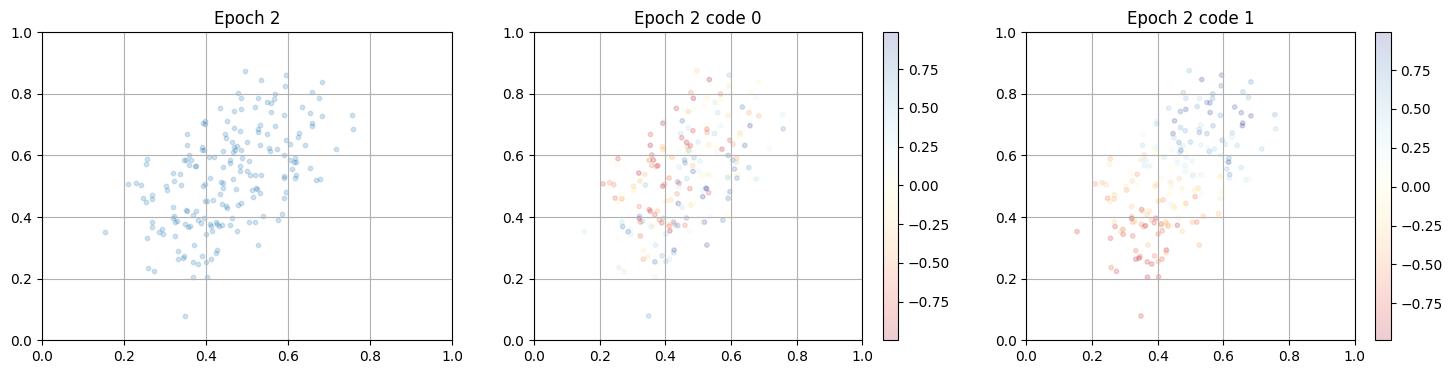

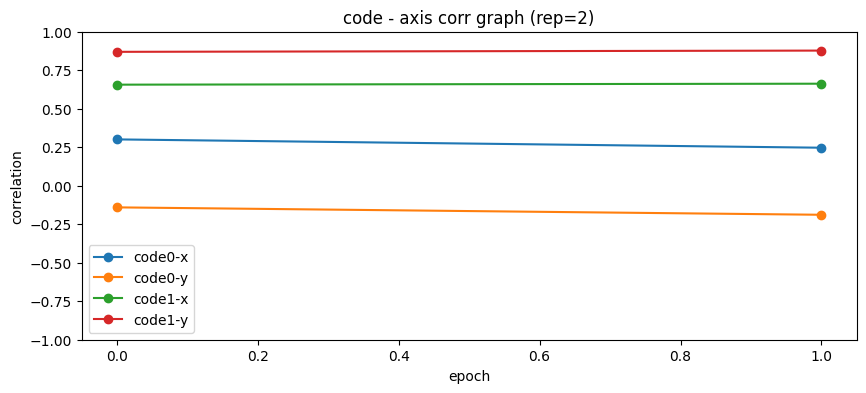

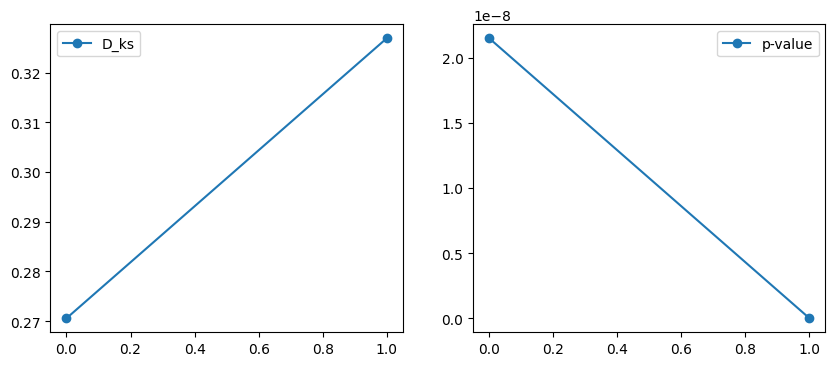

100%|██████████| 12/12 [00:14<00:00,  1.22s/it, G_loss=-.699, D_loss=0.694, MI=0.0452]


epoch: 3, D_loss: 0.6940969526767731, G_loss: -0.6988985041777293, MI = 0.045171802242596946
a_loss: -16.773564100265503, b_loss: 14.539215168849474
좌표값 평균 =  0.43265486 0.54205817


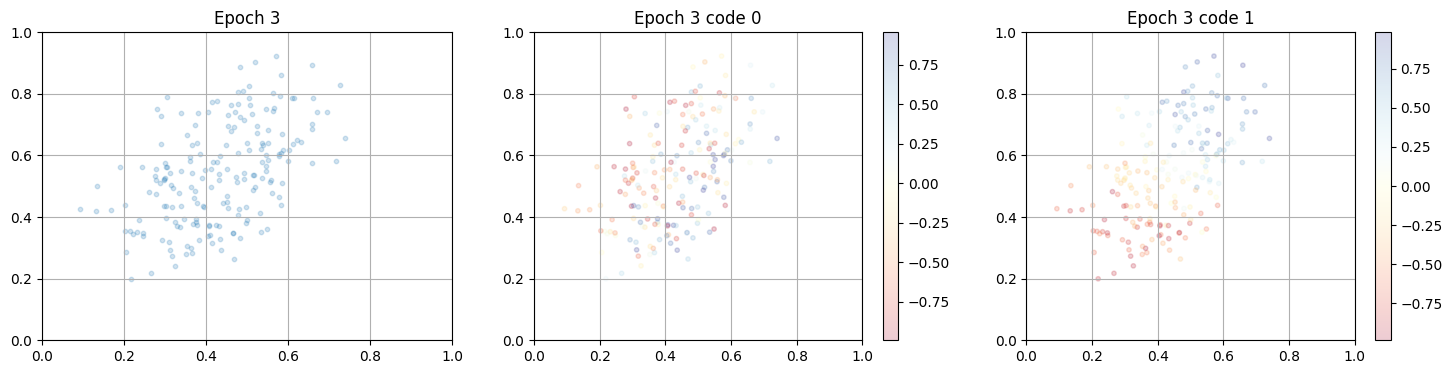

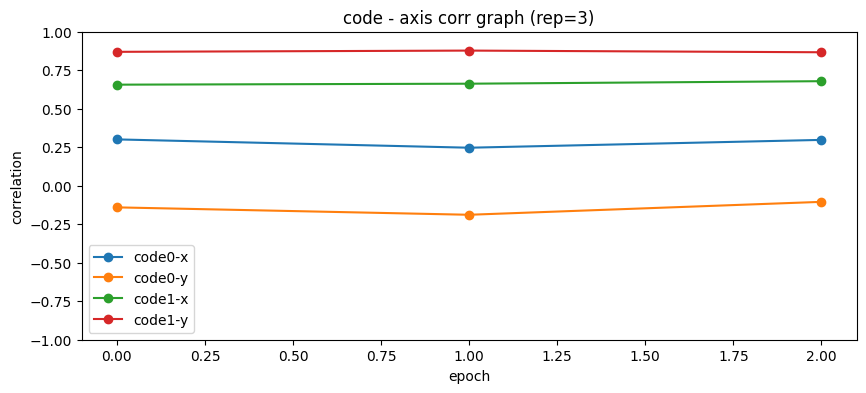

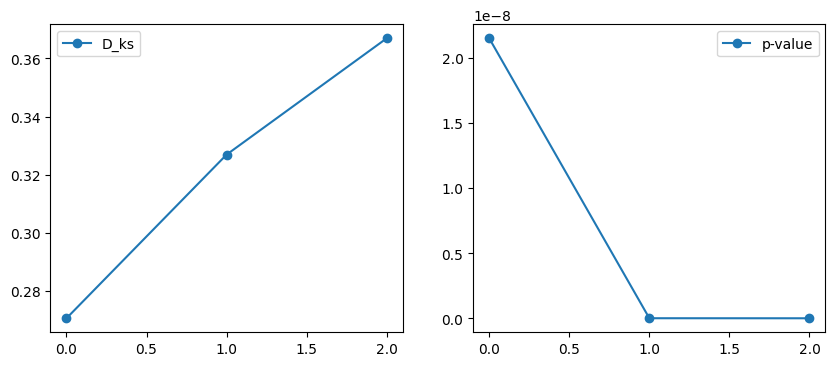

100%|██████████| 12/12 [00:14<00:00,  1.25s/it, G_loss=-.698, D_loss=0.693, MI=0.0549]


epoch: 4, D_loss: 0.6934791555007299, G_loss: -0.6984198093414307, MI = 0.05487785115838051
a_loss: -16.762075424194336, b_loss: 13.789820657210855
좌표값 평균 =  0.42266503 0.56163377


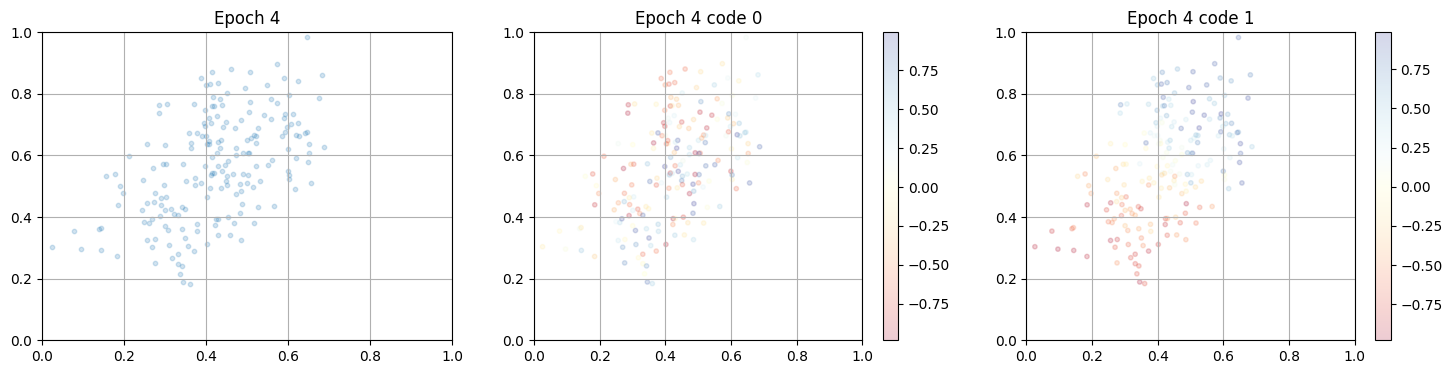

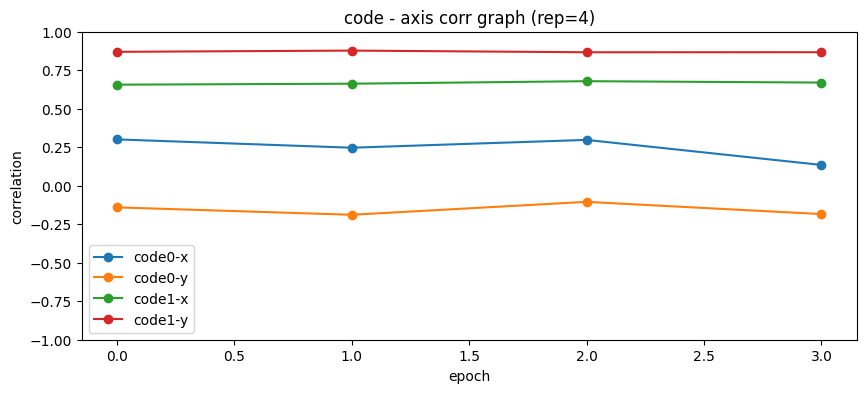

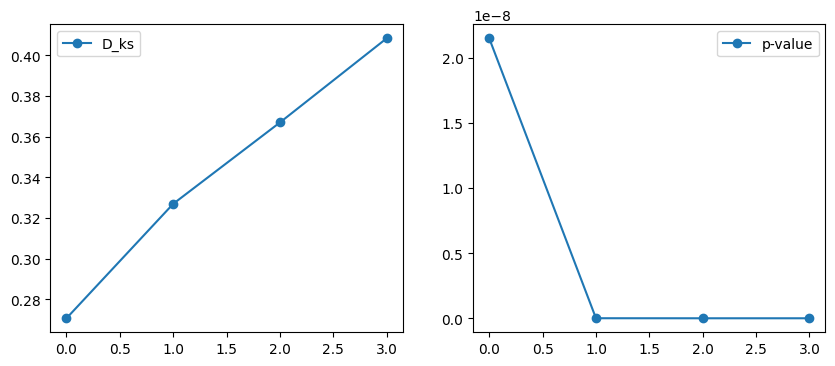

100%|██████████| 12/12 [00:14<00:00,  1.23s/it, G_loss=-.698, D_loss=0.692, MI=0.0586]


epoch: 5, D_loss: 0.6924790094296137, G_loss: -0.6982981115579605, MI = 0.058557868003845215
a_loss: -16.759154677391052, b_loss: 13.768600508921217
좌표값 평균 =  0.4207329 0.5475118


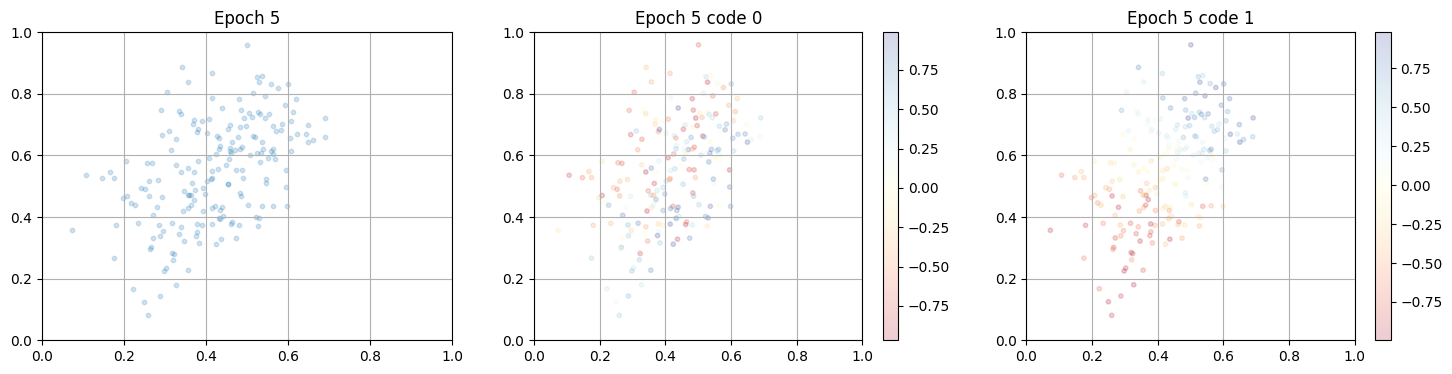

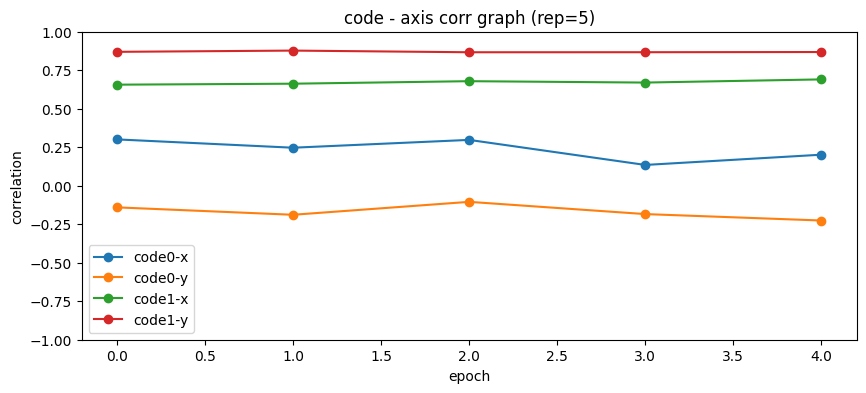

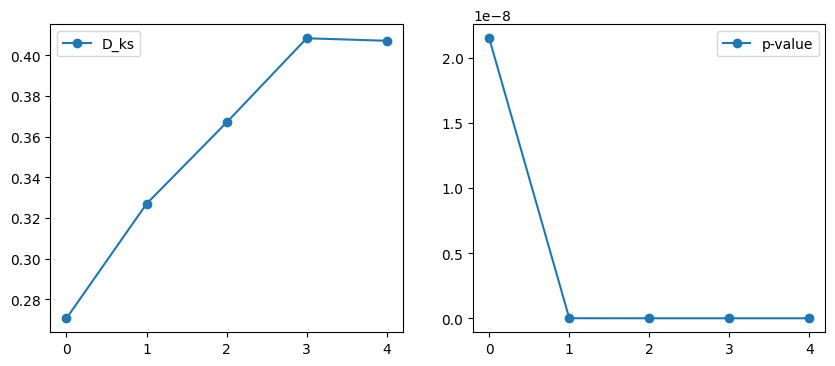

 75%|███████▌  | 9/12 [00:11<00:03,  1.30s/it, G_loss=-.702, D_loss=0.692, MI=0.0672]


KeyboardInterrupt: 

In [34]:
import ndtest
import openpyxl
epoch = 300

recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi', 'D_ks', 'p-value']
for i in range(code_qubits):
    recorder_keywords.append(f'code{i}-x')
    recorder_keywords.append(f'code{i}-y')

recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = int(len(x)//BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    a_loss_sum = 0.0
    b_loss_sum = 0.0
    mi_sum = 0.0
    pbar = tqdm(range(iter_num))
    log_gen_outputs = []
    log_gen_codes = []
    
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss, a, b = generator_train_step(generator_params, generator_seed, use_mine=use_mine, _qmine=use_qmine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()


        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.
        a_loss_sum += a.item()
        b_loss_sum += b.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['a_loss'].append(a_loss_sum/iter_num)
    recorder['b_loss'].append(b_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))
    print("좌표값 평균 = ", np.mean(log_gen_outputs[:,0]), np.mean(log_gen_outputs[:,1]))

    df = pd.DataFrame({'x': log_gen_outputs[:, 0], 'y': log_gen_outputs[:, 1]})
    for i in range(code_qubits):
        df[f'code{i}']=log_gen_codes[:, i]
    corr_mat = df.corr().to_numpy()
    for i in range(code_qubits):
        recorder[f'code{i}-x'].append(corr_mat[0, i+2])
        recorder[f'code{i}-y'].append(corr_mat[1, i+2])
    
    p_value, D_ks = ndtest.ks2d2s(log_gen_outputs[:, 0], log_gen_outputs[:, 1], x[:, 0], x[:, 1], extra=True)
    recorder['D_ks'].append(D_ks)
    recorder['p-value'].append(p_value)

    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)

    with open(f'result/{title}/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)


    df = pd.DataFrame(recorder)
    output_filename = f'result/{title}/recorder.xlsx'
    df.to_excel(output_filename, index=False)

    final_rep = rep

## 모든 지표 엑셀파일로 저장

In [ ]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filename, index=False)

## 결과 plot하는 코드

In [ ]:
import matplotlib.pyplot as plt
plot_list = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
for key in plot_list:
    plt.figure()
    plt.title(key)
    plt.plot(recorder[key])
    plt.savefig(f'result/{title}/{key}.png')
    plt.show()


## 모델 저장 스크립트

In [ ]:
with open(f'result/{title}/discriminator.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator.pkl', 'wb') as file:
    pickle.dump(generator_params, file)

In [ ]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output, _ = generator_forward(generator_params, z)
        generator_output = generator_output.cpu().numpy().reshape(output_qubits)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'{title} result: code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()


In [ ]:
outputs = np.array(outputs)
plt.scatter(outputs[:, 0], outputs[:, 1], s=17, alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame({'x': outputs[:, 0], 'y': outputs[:, 1]})
for i in range(code_qubits):
    df[f'code{i}']=inputs[:, i]
corr_mat = df.corr()
corr_mat

In [ ]:
print(corr_mat.to_numpy()[-2:, :2])

In [ ]:
corr_mat

## 모델 불러오는 스크립트

title변수가 디렉토리를 지정합니다.

In [ ]:
import pickle

with open(f'result/{title}/discriminator2.pkl', 'rb') as file:
    discriminator = pickle.load(file)

with open(f'result/{title}/generator.pkl', 'rb') as file:
    generator_params = pickle.load(file)

In [ ]:
title = 'try14'

In [ ]:
with open(f'result/{title}/discriminator2.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator2.pkl', 'wb') as file:
    pickle.dump(generator_params, file)